<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/210228_cat_dog_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
! mkdir -p ~/.kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 27.7MB/s]
100% 541M/543M [00:04<00:00, 173MB/s]
100% 543M/543M [00:04<00:00, 134MB/s]
 98% 265M/271M [00:02<00:00, 117MB/s]
100% 271M/271M [00:02<00:00, 95.1MB/s]


In [7]:
!unzip -q train.zip
!unzip -q test1.zip

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, load_img

import os
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

np.random.seed(121)
tf.random.set_seed(121)

def CHART_PLOT_HISTORY(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],    label='acc')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'val_acc')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],    label='loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'val_loss')
    plt.legend()
    plt.show()

### 파일 불러오기

In [10]:
train_file_list = os.listdir('./train')
print("train img:", len(train_file_list))

test_file_list = os.listdir('./test1')
print("test img:", len(test_file_list))

train img: 25000
test img: 12500


### dataframe 만들기

In [11]:
label_list = []
fname_list = []
for tfile in train_file_list:
    label_list.append(tfile.split(".")[0])
    fname_list.append(tfile)

In [14]:
train_df = pd.DataFrame({"fname":fname_list, "label":label_list})
train_df["label"] = train_df["label"].apply(lambda x : 0 if x == "cat" else 1).astype("int32")

In [26]:
test_df = pd.DataFrame({"fname":test_file_list})
print(train_df.shape, test_df.shape)
# print(train_df.info())
# print(train_df.head())
print(train_df.tail())
print(test_df.head())

(25000, 2) (12500, 1)
               fname  label
24995   dog.7577.jpg      1
24996  cat.11575.jpg      0
24997   cat.8227.jpg      0
24998   cat.4490.jpg      0
24999   cat.8759.jpg      0
       fname
0    800.jpg
1   4078.jpg
2  12237.jpg
3  11509.jpg
4   1779.jpg


### 이미지 확인

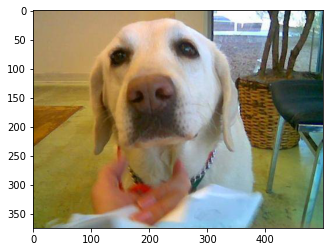

In [18]:
img_object = load_img("./train/"+fname_list[77])
plt.imshow(img_object)
plt.show()

### 학습용(train) 7:3으로 나누기

In [19]:
train_df8, train_df2 = train_test_split(train_df,
                 test_size=0.2,
                 random_state=111)

### 학습용 image 스케일변환 & 증강

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
flow_train_img = train_datagen.flow_from_dataframe(train_df8,
                                        directory="./train",
                                        x_col='fname',
                                        y_col='label',
                                        target_size=(128, 128),
                                        batch_size=100, class_mode='raw'
                                         )

Found 20000 validated image filenames.


### 검증용 image 스케일 변환

In [28]:
flow_val_img = train_datagen.flow_from_dataframe(train_df2,
                                        directory="./train",
                                        x_col='fname',
                                        y_col='label',
                                        target_size=(128, 128),
                                        batch_size=100, class_mode='raw')

Found 5000 validated image filenames.


### 테스트용 image 스케일 변환

In [43]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
flow_test_img = test_datagen.flow_from_dataframe(test_df,
                                        directory="./test1",
                                        x_col='fname',
                                        y_col=None,
                                        target_size=(128, 128),
                                        batch_size=100, class_mode=None
                                         )

Found 12500 validated image filenames.


### 모델 생성

In [30]:
model = Sequential()
model.add(Conv2D(filters=20,kernel_size=(4,4), input_shape=(128,128,3), activation='relu')    )
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=40, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
# model.add(Dense(1, activation='sigmoid'))
# print(model.summary())
early_stop = EarlyStopping(monitor='loss', patience=10)   #Available metrics are: loss,accuracy
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy', #손실함수 cost loss
              metrics=["accuracy"])

### 학습

In [31]:
history = model.fit( #_generator(
                    flow_train_img,   #X_train, y_train
                    steps_per_epoch=np.ceil(train_df8.shape[0]/100),  #batch_size=17500/350=150
                    epochs=3,
                    callbacks=[early_stop],
                    validation_data=(flow_val_img), #validation_data=(X_test, y_test)
                    validation_steps=np.ceil(train_df2.shape[0]/100))

Epoch 1/3
200/200 [==============================] - 417s 2s/step - loss: 0.7107 - accuracy: 0.5686 - val_loss: 0.6242 - val_accuracy: 0.6440
Epoch 2/3
200/200 [==============================] - 425s 2s/step - loss: 0.5944 - accuracy: 0.6799 - val_loss: 0.5699 - val_accuracy: 0.7050
Epoch 3/3
200/200 [==============================] - 413s 2s/step - loss: 0.5668 - accuracy: 0.7071 - val_loss: 0.5485 - val_accuracy: 0.7178


### 평가 & 차트

In [39]:
# print(model_generator.evaluate(test_datagen))

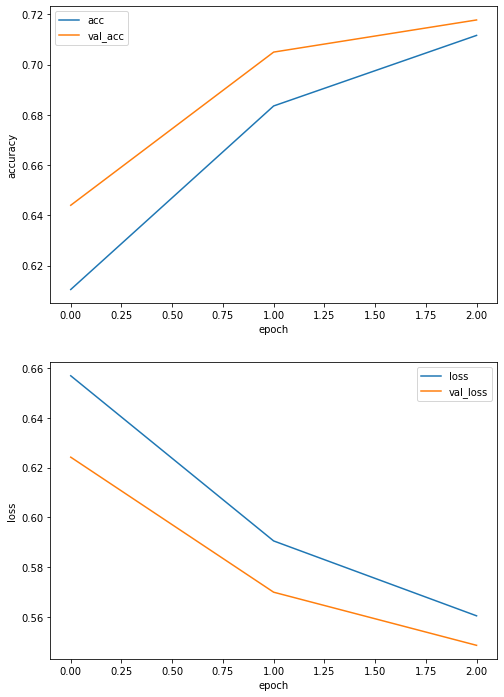

In [35]:
CHART_PLOT_HISTORY(history)

### 예측 

In [45]:
#  pred = model.predict_generator(test_datagen, step=np.ceil())

In [41]:
# pred_ = np.argmax(pred).reshape(-1,1)